# Optimal control of storage
## Task 11
### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose

try:
    from prophet import Prophet
except ImportError:
    from fbprophet import Prophet

from pyomo.environ import (
    ConcreteModel, Var, NonNegativeReals, Reals,
    Objective, Constraint, ConstraintList, RangeSet,
    minimize, SolverFactory, value, inequality
)

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

## Functions

In [2]:
def preprocess_hourly(df: pd.DataFrame) -> pd.DataFrame:
    # sort → datetime index → tz-naive → hourly grid → interpolate numeric
    df = df.sort_values("timestamp").set_index("timestamp")
    try:
        df.index = df.index.tz_convert(None)
    except Exception:
        df.index = df.index.tz_localize(None)

    df = df.resample("h").asfreq()

    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].interpolate(method="time").ffill().bfill()

    df.index.freq = "h"
    return df

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def metrics_dict(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE_%": mean_absolute_percentage_error(y_true, y_pred) * 100
    }


## Load data

In [3]:
train_raw = pd.read_csv("train_253253.csv", parse_dates=["timestamp"])
fcst_raw  = pd.read_csv("forecast.csv",      parse_dates=["timestamp"])
optim_raw  = pd.read_csv("optimisation.csv", parse_dates=["timestamp"])

train = preprocess_hourly(train_raw)
fcst  = preprocess_hourly(fcst_raw)
optim_df  = preprocess_hourly(optim_raw)


# df = pd.read_csv("forecast.csv", parse_dates=["timestamp"])
# df = df.sort_values("timestamp").reset_index(drop=True)
# df = df.set_index("timestamp")
# df = df.asfreq("h") 
#df = df.resample("h").asfreq()
optim_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2014-07-08 00:00:00 to 2014-07-08 23:00:00
Freq: h
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pv_low                           24 non-null     float64
 1   pv_high                          24 non-null     float64
 2   Price                            24 non-null     float64
 3   Temperature                      24 non-null     float64
 4   Pressure (hPa)                   24 non-null     float64
 5   Cloud_cover (%)                  24 non-null     int64  
 6   Cloud_cover_low (%)              24 non-null     int64  
 7   Cloud_cover_mid (%)              24 non-null     int64  
 8   Cloud_cover_high (%)             24 non-null     int64  
 9   Wind_speed_10m (km/h)            24 non-null     float64
 10  Shortwave_radiation (W/m²)       24 non-null     int64  
 11  direct_radiation (W/m²)          24 non-

## Rolling setup for ML model training

In [4]:
start_day = fcst.index.min().normalize()
day_starts = [start_day + pd.Timedelta(days=i) for i in range(7)]
day_starts

[Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-07-02 00:00:00'),
 Timestamp('2014-07-03 00:00:00'),
 Timestamp('2014-07-04 00:00:00'),
 Timestamp('2014-07-05 00:00:00'),
 Timestamp('2014-07-06 00:00:00'),
 Timestamp('2014-07-07 00:00:00')]

## Build rolling windows

In [46]:
windows = {}

for day_start in day_starts:
    day_end = day_start + pd.Timedelta(hours=24)

    # 0h lead-time history: train + forecast hours strictly before day_start
    hist = pd.concat([train, fcst.loc[:day_start - pd.Timedelta(hours=1)]], axis=0)

    # 24h block to forecast (true Demand exists in forecast.csv for evaluation)
    block = fcst.loc[day_start:day_end - pd.Timedelta(hours=1)].copy()
    y_true = block["Demand"].values

    windows[day_start] = {
        "hist": hist,
        "block": block, 
        "y_true": y_true,
    }

# show what training is based on (first day)
d0 = day_starts[0]
print("DAY:", d0.date())
print("TRAIN(hist):", windows[d0]["hist"].index.min(), "->", windows[d0]["hist"].index.max(), "| rows:", len(windows[d0]["hist"]))
print("TEST(block):", windows[d0]["block"].index.min(), "->", windows[d0]["block"].index.max(), "| rows:", len(windows[d0]["block"]))


DAY: 2014-07-01
TRAIN(hist): 2013-07-01 00:00:00 -> 2014-06-30 23:00:00 | rows: 8760
TEST(block): 2014-07-01 00:00:00 -> 2014-07-01 23:00:00 | rows: 24


## Fit models first (per day): Prophet

In [6]:
models = {"Prophet": {}}

for day_start in day_starts:
    hist = windows[day_start]["hist"]

    # Prophet = direct/one-shot multi-horizon forecast
    prop_train = hist[["Demand"]].reset_index()
    prop_train.columns = ["ds", "y"]
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
    m.add_country_holidays(country_name="EE")
    m.fit(prop_train)
    models["Prophet"][day_start] = m

print({k: len(v) for k, v in models.items()})

11:45:12 - cmdstanpy - INFO - Chain [1] start processing
11:45:13 - cmdstanpy - INFO - Chain [1] done processing
11:45:13 - cmdstanpy - INFO - Chain [1] start processing
11:45:14 - cmdstanpy - INFO - Chain [1] done processing
11:45:15 - cmdstanpy - INFO - Chain [1] start processing
11:45:15 - cmdstanpy - INFO - Chain [1] done processing
11:45:16 - cmdstanpy - INFO - Chain [1] start processing
11:45:16 - cmdstanpy - INFO - Chain [1] done processing
11:45:17 - cmdstanpy - INFO - Chain [1] start processing
11:45:17 - cmdstanpy - INFO - Chain [1] done processing
11:45:18 - cmdstanpy - INFO - Chain [1] start processing
11:45:19 - cmdstanpy - INFO - Chain [1] done processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing


{'Prophet': 7}


## Forecast 1 day for optimisation.csv

In [9]:
# --- Task 11.1: demand forecast for next 24h using Prophet only ---

opt_raw = pd.read_csv("optimisation.csv", parse_dates=["timestamp"])
opt = preprocess_hourly(opt_raw)  # same function as in Task 9
opt = opt.reset_index().rename(columns={"timestamp": "ds"})  # Prophet uses "ds"
opt = opt.sort_values("ds")

# take the next 24 hours from optimisation horizon (file already contains 24h)
future_24h = opt[["ds"]].iloc[:24].copy()

# (for yourself) check horizon
print("Optimisation horizon:", future_24h["ds"].min(), "->", future_24h["ds"].max(), "| rows:", len(future_24h))

# Fit Prophet ONCE using all available training demand (recommended for Task 11)
# If you already have a fitted Prophet model from Task 9, you can reuse it.
prop_train_full = train[["Demand"]].reset_index()
prop_train_full.columns = ["ds", "y"]

m_demand = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
m_demand.add_country_holidays(country_name="EE")
m_demand.fit(prop_train_full)

# Forecast demand for the 24h optimisation window
fcst_24h = m_demand.predict(future_24h)

# final demand forecast series
demand_forecast_24h = fcst_24h.set_index("ds")["yhat"]

display(fcst_24h[["ds", "yhat", "yhat_lower", "yhat_upper"]].head())
demand_forecast_24h.head()


Optimisation horizon: 2014-07-08 00:00:00 -> 2014-07-08 23:00:00 | rows: 24


11:45:49 - cmdstanpy - INFO - Chain [1] start processing
11:45:50 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2014-07-08 00:00:00,0.253286,-0.176643,0.663011
1,2014-07-08 01:00:00,0.222787,-0.192997,0.648282
2,2014-07-08 02:00:00,0.196623,-0.245455,0.648214
3,2014-07-08 03:00:00,0.170246,-0.275120,0.592626
4,2014-07-08 04:00:00,0.169672,-0.238920,0.613111


ds
2014-07-08 00:00:00    0.253286
2014-07-08 01:00:00    0.222787
2014-07-08 02:00:00    0.196623
2014-07-08 03:00:00    0.170246
2014-07-08 04:00:00    0.169672
Name: yhat, dtype: float64

## Demand plot

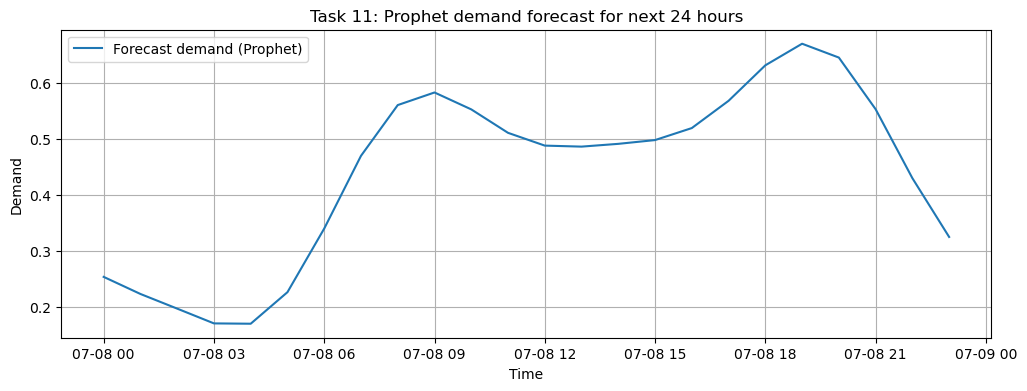

In [10]:
plt.figure(figsize=(12,4))
plt.plot(demand_forecast_24h.index, demand_forecast_24h.values, label="Forecast demand (Prophet)")
plt.grid(True)
plt.legend()
plt.title("Task 11: Prophet demand forecast for next 24 hours")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.show()


## defining Pyomo model

In [11]:
def optimize_ems_pyomo(
    df,
    bess_capacity_kwh=10.0,
    batt_p_ch_max_kw=5.0,
    batt_p_dis_max_kw=5.0,
    grid_p_max_kw=5.0,
    bess_init_kwh=5.0,
    bess_min_kwh=0.5,
    bess_max_kwh=9.5,
    gamma=0.8,
    solver_name="cplex",
    verbose=False,
):
    """Single-shot EMS optimization using Pyomo.

    Expects df to contain columns:
    - 'Price'
    - 'Demand'
    - 'PV Generation'
    """
    dt = 1.0  # hours per timestep (hourly data)
    T = len(df)

    price = df["Price"].values.astype(float)
    demand = df["Demand"].values.astype(float)
    pv = df["PV Generation"].values.astype(float)

    # ------------------------------------------------------------------
    # Pyomo model
    # ------------------------------------------------------------------
    m = ConcreteModel()

    # Time indices: 0 .. T-1
    m.T = RangeSet(0, T - 1)
    # Battery energy indices: 0 .. T  (T+1 states)
    m.Tsoc = RangeSet(0, T)

    # Decision variables
    m.P_grid_pos = Var(m.T, domain=NonNegativeReals)   # grid import (kW)
    m.P_grid_neg = Var(m.T, domain=NonNegativeReals)   # grid export (kW)
    m.P_charge   = Var(m.T, domain=NonNegativeReals)   # battery charging power (kW)
    m.P_discharge = Var(m.T, domain=NonNegativeReals)  # battery discharging power (kW)
    m.bess_energy = Var(m.Tsoc, domain=Reals)          # state of charge (kWh-like units)

    # ------------------------------------------------------------------
    # Objective: minimize cost of energy = import*price - gamma*export*price
    # ------------------------------------------------------------------
    def obj_rule(model):
        return sum(
            (model.P_grid_pos[t] * price[t] * dt
             - model.P_grid_neg[t] * price[t] * gamma * dt)
            for t in model.T
        )

    m.obj = Objective(rule=obj_rule, sense=minimize)

    # ------------------------------------------------------------------
    # Constraints
    # ------------------------------------------------------------------
    m.constraints = ConstraintList()

    # Initial SOC
    m.constraints.add(m.bess_energy[0] == bess_init_kwh)

    # SOC dynamics (kept identical to original CVXPY version):
    # E[t+1] = E[t] + (P_charge[t] - P_discharge[t]) * dt / bess_capacity_kwh
    for t in m.T:
        m.constraints.add(
            m.bess_energy[t + 1]
            == m.bess_energy[t]
            + (m.P_charge[t] - m.P_discharge[t]) * dt / bess_capacity_kwh
        )

    # SOC bounds
    for t in m.Tsoc:
        m.constraints.add(
            inequality(bess_min_kwh, m.bess_energy[t], bess_max_kwh)
        )

    # Power bounds
    for t in m.T:
        m.constraints.add(m.P_charge[t] <= batt_p_ch_max_kw)
        m.constraints.add(m.P_discharge[t] <= batt_p_dis_max_kw)
        m.constraints.add(m.P_grid_pos[t] <= grid_p_max_kw)
        m.constraints.add(m.P_grid_neg[t] <= grid_p_max_kw)

    # Power balance: grid + battery + PV must cover demand
    for t in m.T:
        m.constraints.add(
            m.P_grid_pos[t] - m.P_grid_neg[t]
            + m.P_discharge[t] - m.P_charge[t]
            + pv[t] == demand[t]
        )

    # ------------------------------------------------------------------
    # Solve
    # ------------------------------------------------------------------
    solver = SolverFactory(solver_name)
    results = solver.solve(m, tee=verbose)

    # ------------------------------------------------------------------
    # Collect results into a DataFrame
    # ------------------------------------------------------------------
    res = pd.DataFrame(index=df.index.copy())

    res["P_grid_import_kW"] = [value(m.P_grid_pos[t]) for t in m.T]
    res["P_grid_export_kW"] = [value(m.P_grid_neg[t]) for t in m.T]
    res["P_grid_net_kW"] = (
        res["P_grid_import_kW"] - res["P_grid_export_kW"]
    )

    res["P_charge_kW"] = [value(m.P_charge[t]) for t in m.T]
    res["P_discharge_kW"] = [value(m.P_discharge[t]) for t in m.T]
    res["P_bess_net_kW"] = (
        res["P_discharge_kW"] - res["P_charge_kW"]
    )

    # Drop the last SOC element to align with time steps
    res["bess_kWh"] = [value(m.bess_energy[t]) for t in range(T)]

    # Copy original series for convenience
    res["PV_kW"] = df["PV Generation"].values
    res["Demand_kW"] = df["Demand"].values
    res["Price"] = df["Price"].values

    # Compute total cost (same formula as in original script)
    total_cost = float(
        np.sum(
            res["P_grid_import_kW"] * res["Price"] * dt
            - res["P_grid_export_kW"] * res["Price"] * gamma * dt
        )
    )

    return res, total_cost

## Defining PV low ang high parameters for Pyomo modeling

In [12]:
# demand_forecast_24h: Series index=timestamp, values=forecasted demand
opt_df = optim_df.copy()  # из optimisation.csv, 24h

opt_df["Demand"] = demand_forecast_24h.reindex(opt_df.index).values

# case A: PV low
df_low = pd.DataFrame({
    "Price": opt_df["Price"],
    "Demand": opt_df["Demand"],
    "PV Generation": opt_df["pv_low"]
}, index=opt_df.index)

res_low, cost_low = optimize_ems_pyomo(df_low, solver_name="glpk")

# case B: PV high
df_high = pd.DataFrame({
    "Price": opt_df["Price"],
    "Demand": opt_df["Demand"],
    "PV Generation": opt_df["pv_high"]
}, index=opt_df.index)

#res_high, cost_high = optimize_ems_pyomo(df_high, solver_name="highs")

## Applying Pyomo model for PV low

In [17]:
# Run the Pyomo-based optimization
results_low, cost_low = optimize_ems_pyomo(
    df_low,
    bess_capacity_kwh=10.0,
    batt_p_ch_max_kw=5.0,
    batt_p_dis_max_kw=5.0,
    grid_p_max_kw=5.0,
    bess_init_kwh=5.0,
    bess_min_kwh=0.5,
    bess_max_kwh=9.5,
    gamma=1,
    solver_name="glpk",  # change if you use another solver
    verbose=False,
)

print(f"Total cost over horizon (Pyomo): {cost_low:.2f} €")
results_low.head()

Total cost over horizon (Pyomo): -4.34 €


,P_grid_import_kW,P_grid_export_kW,P_grid_net_kW,P_charge_kW,P_discharge_kW,P_bess_net_kW,bess_kWh,PV_kW,Demand_kW,Price
timestamp,,,,,,,,,,
2014-07-08 00:00:00,5.0,0.000000,5.000000,4.746714,0.000000,-4.746714,5.000000,0.0,0.253286,0.06096
2014-07-08 01:00:00,0.0,2.952379,-2.952379,0.000000,3.175165,3.175165,5.474671,0.0,0.222787,0.07006
2014-07-08 02:00:00,5.0,0.000000,5.000000,4.803377,0.000000,-4.803377,5.157155,0.0,0.196623,0.07005
2014-07-08 03:00:00,5.0,0.000000,5.000000,4.829754,0.000000,-4.829754,5.637493,0.0,0.170246,0.05500
2014-07-08 04:00:00,5.0,0.000000,5.000000,4.830328,0.000000,-4.830328,6.120468,0.0,0.169672,0.05757


## Applying Pyomo model for PV low ang high

In [18]:
# Run the Pyomo-based optimization
results_high, cost_high = optimize_ems_pyomo(
    df_high,
    bess_capacity_kwh=10.0,
    batt_p_ch_max_kw=5.0,
    batt_p_dis_max_kw=5.0,
    grid_p_max_kw=5.0,
    bess_init_kwh=5.0,
    bess_min_kwh=0.5,
    bess_max_kwh=9.5,
    gamma=1,
    solver_name="glpk",  # change if you use another solver
    verbose=False,
)

print(f"Total cost over horizon (Pyomo): {cost_high:.2f} €")
results_high.head()

Total cost over horizon (Pyomo): -5.23 €


,P_grid_import_kW,P_grid_export_kW,P_grid_net_kW,P_charge_kW,P_discharge_kW,P_bess_net_kW,bess_kWh,PV_kW,Demand_kW,Price
timestamp,,,,,,,,,,
2014-07-08 00:00:00,5.0,0.000000,5.000000,4.746714,0.000000,-4.746714,5.000000,0.0,0.253286,0.06096
2014-07-08 01:00:00,0.0,4.755727,-4.755727,0.000000,4.978514,4.978514,5.474671,0.0,0.222787,0.07006
2014-07-08 02:00:00,5.0,0.000000,5.000000,4.803377,0.000000,-4.803377,4.976820,0.0,0.196623,0.07005
2014-07-08 03:00:00,5.0,0.000000,5.000000,4.829754,0.000000,-4.829754,5.457158,0.0,0.170246,0.05500
2014-07-08 04:00:00,5.0,0.000000,5.000000,4.830328,0.000000,-4.830328,5.940133,0.0,0.169672,0.05757


## Plots

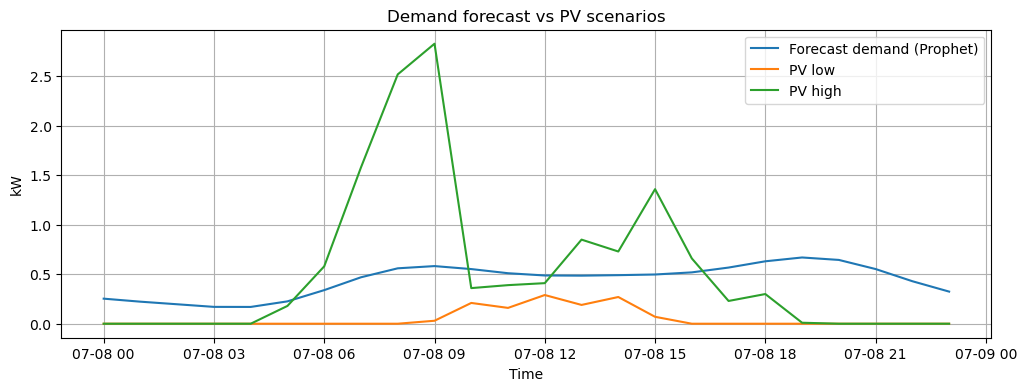

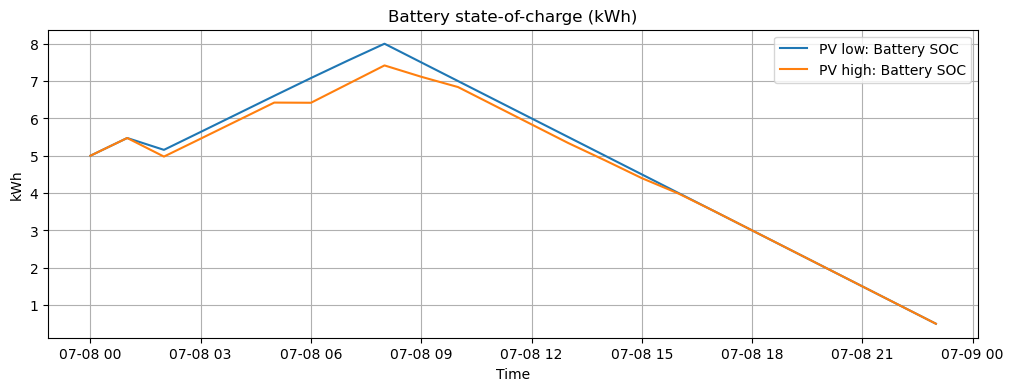

<Figure size 1200x600 with 0 Axes>

In [43]:
# 1) PV generation vs Demand
plt.figure(figsize=(12,4))
plt.plot(demand_forecast_24h.index, demand_forecast_24h.values, label="Forecast demand (Prophet)")
plt.plot(results_low.index, results_low["PV_kW"],     label="PV low")
plt.plot(high.index, results_high["PV_kW"],   label="PV high")
plt.grid(True); plt.legend()
plt.title("Demand forecast vs PV scenarios")
plt.xlabel("Time"); plt.ylabel("kW")
plt.show()

# 2) Battery SOC comparison
plt.figure(figsize=(12,4))
plt.plot(results_low.index,  results_low["bess_kWh"],  label="PV low: Battery SOC")
plt.plot(results_high.index, results_high["bess_kWh"], label="PV high: Battery SOC")
plt.grid(True); plt.legend()
plt.title("Battery state-of-charge (kWh)")
plt.xlabel("Time"); plt.ylabel("kWh")
plt.show()

plt.tight_layout()
plt.show()

## Comparison table

In [48]:
gamma = 1
dt = 1.0  # hourly

def compute_kpis(res, cost, gamma=1, dt=1.0):
    # energy sums (kWh over horizon)
    grid_import_kwh = float((res["P_grid_import_kW"] * dt).sum())
    grid_export_kwh = float((res["P_grid_export_kW"] * dt).sum())
    pv_gen_kwh      = float((res["PV_kW"] * dt).sum())
    demand_kwh      = float((res["Demand_kW"] * dt).sum())

    total_cost = float(cost)

    return {
        "Total cost [€]": total_cost,
        "Grid import [kWh]": grid_import_kwh,
        "Grid export [kWh]": grid_export_kwh,
        "PV generation [kWh]": pv_gen_kwh,
        "Demand [kWh]": demand_kwh,
    }

# Key Performance Indicators (KPI table
kpi_low  = compute_kpis(results_low, cost_low, gamma=gamma, dt=dt)
kpi_high = compute_kpis(results_high, cost_high, gamma=gamma, dt=dt)

kpi_tbl = pd.DataFrame([kpi_low, kpi_high], index=["PV low", "PV high"]).T
display(kpi_tbl)

# headline comparison
cost_delta = float(kpi_low["Total cost [€]"] - kpi_high["Total cost [€]"])
print(f"Cost(PV low)  = {kpi_low['Total cost [€]']:.2f} €")
print(f"Cost(PV high) = {kpi_high['Total cost [€]']:.2f} €")
print(f"PV high improves cost by {cost_delta:.2f} € over 24h (more negative = better here).")


,PV low,PV high
Total cost [€],-4.338470,-5.234731
Grid import [kWh],35.324562,28.973550
Grid export [kWh],70.991154,76.410142
PV generation [kWh],1.220000,12.990000
Demand [kWh],10.553408,10.553408


Cost(PV low)  = -4.34 €
Cost(PV high) = -5.23 €
PV high improves cost by 0.90 € over 24h (more negative = better here).
